# CMPE 462 - Project Phase 1

Muhammed Furkan Atasoy, 2017400216

Zehranaz Canfes, 2017205138

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [ ]:
def sample_sphere(r=1, npoints=1000):
    dr = np.random.rand(npoints,1)
    theta = 2*np.pi*np.random.rand(npoints,1)
    x = dr * np.cos(theta)
    y = dr * np.sin(theta)
    return np.hstack((x,y))

In [ ]:
def create_dataset(npoints=1000):
    points = sample_sphere(npoints=npoints) 
    points = np.hstack((np.ones(npoints).reshape(npoints,1), points))
    labels = np.sign(points[:, 2])
    return points, labels

In [ ]:
points, labels = create_dataset()
points.shape, labels.shape

((1000, 3), (1000,))

## 1.a)

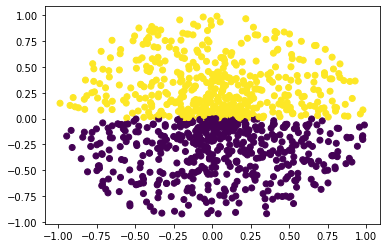

In [ ]:
plt.scatter(points[:, 1], points[:, 2], c=labels)

## 1.b)

In [ ]:
w = np.zeros(shape=(3, 1))
x = points.T
y = labels

is_looked = np.array([False]*1000)

while(True):
  mis_indexes = np.where(((np.sign(w.T @ x) != y)[0, :]) & (is_looked == False))[0]

  if len(mis_indexes) == 0:
    break

  mis_index = mis_indexes[0]

  y_star = y[mis_index]
  x_star = np.expand_dims(x[:, mis_index], axis=1)

  w = w + y_star * x_star

  is_looked[mis_index] = True

In [ ]:
def pred(x, w):
  return np.sign(w.T @ x)

### Accuracy

In [ ]:
print("Accuracy:", np.sum(pred(x, w) == y)/len(y))

Accuracy: 0.999


### Decision Boundary

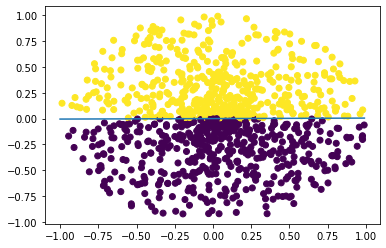

In [ ]:
x1 = np.arange(-1, 1, 0.01)
x2 = -w[1, 0]/w[2, 0]*x1 - w[0, 0] / w[2, 0]

plt.scatter(x[1, :], x[2, :], c=pred(x, w))
plt.plot(x1, x2)

## 1.c)


Consider the AND function as sample

$$x_1$$  | $$x_2$$ |y|
----|----|---|
0   | 0  |  0|
0   | 1  |  0|
1   | 0  |  0|
1   | 1  |  1|

This sample is linearly seperable. 

### With Bias

With bias, the line describing the decision boundary is defined by: 

$$
w_1x_1+w_2x_2+w_0=0\\
\implies x_2=-(w_1/w_2)x_1-(w_0/w_2)
$$

So, the line 

$$ 
x_2 = -x_1+\frac{3}{2} 
$$ 
seperates the sample.



### Without Bias

Without bias, the line describing the decision boundary is defined by: 

$$ 
w_1x_1+w_2x_2=0\\
\implies x_2 = -(w_1/w_2)x_1
$$ 

Therefore, the decision boundary **should** pass through the **origin**. Here, the decision boundary should seperate the point $(1,1)$ from other data points. Considering each line passing through origin, none of them can seperate the dataset. The $x$- and $y$-intercept of the decision boundary should be positive to be able to seperate the dataset. Moreover, the slope of the line should be negative considering the datapoints' orientation in the $x_1x_2$-plane. Only lines that satisfy these conditions are the ones that **do not** pass through origin. Hence, without bias, the sample of AND is not separable with a perceptron. 

## 2.a)

In [ ]:
import os
from PIL import Image
from natsort import natsorted
import cv2

In [ ]:
# !unzip phase1_files.zip -d phase1_files

In [ ]:
train_path = "phase1_files/3dshapes_train/"
test_path = "phase1_files/3dshapes_test/"

train_img_paths = [train_path+x for x in natsorted(os.listdir(train_path))]
test_img_paths = [test_path+x for x in natsorted(os.listdir(test_path))]

train_imgs = np.array([np.array(Image.open(img_path).convert('L')).reshape(-1) / 255. for img_path in train_img_paths])
test_imgs = np.array([np.array(Image.open(img_path).convert('L')).reshape(-1) / 255. for img_path in test_img_paths])

train_orient = np.load("phase1_files/orientations_train.npy")
test_orient = np.load("phase1_files/orientations_test.npy")

In [ ]:
train_imgs.shape, test_imgs.shape, train_orient.shape, test_orient.shape

((10000, 4096), (1000, 4096), (10000,), (1000,))

## 2.b)

In [ ]:
X = np.append(train_imgs, np.ones((train_imgs.shape[0], 1)), axis=1) # last row is bias term
y = train_orient.reshape(-1, 1)

w_star = np.linalg.pinv(X.T @ X) @ X.T @ y

## 2.c)

In [ ]:
X = np.append(test_imgs, np.ones((test_imgs.shape[0], 1)), axis=1) # last row is bias term 
y = test_orient.reshape(-1, 1)

y_hat = X @ w_star

mse = np.sum((y - y_hat) ** 2) / len(y)

print("MSE:", mse)

MSE: 0.053265961671145154


## 2.d)

### Dimensionality Reduction Method: PCA 

PCA is an unsupervised method to reduce the number of features in a dataset. In the case of images, PCA can be used to compress the vector consisting of pixel values. Because it finds the directions in which data varies most, PCA is a good methodology to compress features of data. Therefore, with a smaller feature vector, our linear regression starts to work efficiently and the computational cost is reduced. 

The final number of features is chosen to be 512. 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=512)

train_imgs_reduced = pca.fit_transform(train_imgs)
test_img_reduced = pca.transform(test_imgs)

In [ ]:
X = np.append(train_imgs_reduced, np.ones((train_imgs_reduced.shape[0], 1)), axis=1) # last row is bias term
y = train_orient.reshape(-1, 1)

w_star = np.linalg.pinv(X.T @ X) @ X.T @ y

In [ ]:
X = np.append(test_img_reduced, np.ones((test_img_reduced.shape[0], 1)), axis=1) # last row is bias term 
y = test_orient.reshape(-1, 1)

y_hat = X @ w_star

mse = np.sum((y - y_hat) ** 2) / len(y)

print("MSE after PCA:", mse)

## References

1. https://towardsdatascience.com/dimensionality-reduction-of-a-color-photo-splitting-into-rgb-channels-using-pca-algorithm-in-python-ba01580a1118

2. https://towardsdatascience.com/image-compression-using-principal-component-analysis-pca-253f26740a9f

3. https://towardsdatascience.com/dimensionality-reduction-approaches-8547c4c44334

4. https://stackoverflow.com/questions/23838056/what-is-the-difference-between-transform-and-fit-transform-in-sklearn